#### *Exercise 6.9*

#### Re-solve the windy gridworld assuming eight possible actions, including the diagonal moves, rather than four. How much better can you do with the extra actions? Can you do even better by including a ninth action that causes no movement at all other than that caused by the wind?

---
#### Resposta 1:

Primeiro estarei replicando o ambiente original. No ambiente original, temos um agente andando para a parte direita da tela onde está o estado terminal, mas um vento leva o agente para cima em um número definido de casas, que depende de onde o agente está em cada momento (posição em x)

In [112]:
import numpy as np
from scipy.stats import t
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

In [50]:
WIND = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

BOUNDS = (10, 7)
GOAL = (7, 3)
START = (0, 3)

UP = (0, 1)
DOWN = (0, -1)
LEFT = (-1, 0)
RIGHT = (1, 0)

UP_LEFT = (-1, 1)
UP_RIGHT = (1, 1)
DOWN_LEFT = (-1, -1)
DOWN_RIGHT = (1, -1)

NOOP = (0, 0)

ACTIONS = [UP, DOWN, LEFT, RIGHT]
ACTIONS_WITH_DIAGONALS = [UP, DOWN, LEFT, RIGHT, UP_LEFT, UP_RIGHT, DOWN_LEFT, DOWN_RIGHT]
ALL_ACTIONS = [UP, DOWN, LEFT, RIGHT, UP_LEFT, UP_RIGHT, DOWN_LEFT, DOWN_RIGHT, NOOP]

In [51]:
def step(pos, action, action_set):
    """Performs an action in the Windy environment

    Given a current position (state) and an action, it returns the new state and a reward. The rules are following the example 6.5 of the book: There is an upward wind, every action works as a normal (up, down, left, right), clipping values to the min and maximum of the grid, which is 10x7. The starting state is (0,3) and the goal is (7,3). The reward is -1 if it's not the terminal state and 0 otherwise.

    Parameters
    ----------
    pos : Tuple[int, int]
        Current position of the agent.
    action : int
        Action for the agent perform in the environment. The ordering is UP, DOWN, LEFT, RIGHT.
    action_set: list[Tuple[int, int]]
        One of the available action sets, such as ACTIONS and ACTIONS_WITH_DIAGONALS

    Returns
    -------
    Tuple[Tuple[int, int], int, bool]
        A tuple of three values, the first is the position (another tuple, as (x, y)), the second is the reward of performing this action in the given state and the last is a boolean of whether the state is a terminal state.
    """
    x = np.clip(pos[0] + action_set[action][0], 0, 9)
    y = np.clip(pos[1] + action_set[action][1] + WIND[pos[0]], 0, 6)
    
    if (x, y) == GOAL:
        return ((x, y), 0, True)
    else:
        return ((x, y), -1, False)

In [52]:
def plot_state(pos, trajectory=None):
    """Plots the current position and trajectory of the agent.

    Given a position in the format (x,y) and a trajectory as an array of positions, it plots the trajectory of the agent on the environment.

    Parameters
    ----------
    pos : Tuple[int,int]
        Position of the agent as (x,y)
    trajectory : Array[Tuple[int, int]], optional
        Array of positions of the agent, by default None
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_yticks(np.arange(0, 7, 1))
    ax.set_yticks(np.arange(0, 7, 1/3), minor=True)
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_xticks(np.arange(0, 10, 1/3), minor=True)

    ax.grid(which='minor', alpha=0.3)
    ax.grid(which='major', alpha=1)

    plt.xlim([0, 10])
    plt.ylim([0, 7])

    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.text(pos[0] + 0.38, pos[1] + 0.38, "S", fontsize=12)
    plt.text(GOAL[0] + 0.38, GOAL[1] + 0.38, "G", fontsize=12)

    if trajectory:
        plt.plot([ x + 0.5 for (x,y) in trajectory], [y + 0.5 for (x,y) in trajectory])
    
    plt.show()

In [53]:
def epsilon_greedy(Q, S, action_set, epsilon):
    """Episilon greedy policy.

    Given a table of Q values, a state and an action set, this function selects the best action for the given state 1 - epsilon percent of times and chooses a random action epsilon percent of times.

    Parameters
    ----------
    Q : np.ndarray
        N dimensional array where the last dimension is for the action values.
    S : np.ndarray
        The current state, which is of the same shape as Q except for the last dimension.
    action_set : list[Tuple[int, int]]
        List of possible action movements for (mx, my)
    epsilon : float
        The probability of choosing a random action.

    Returns
    -------
    int
        The chosen action by the epsilon-greedy policy.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(0, len(action_set))
    else:
        return np.argmax(Q[S])

In [54]:
def j(a, b):
    """Joins an action and a state into an action-state.

    In order to iterate over Q, this funcion is used to make a tuple of state values and actions.

    Parameters
    ----------
    s : Tuple[int, int]
        Current state (position of the agent)
    a : int
        Chosen action

    Returns
    -------
    Tuple[int, int, int]
        Action-state tuple to iterate over Q
    """
    return (a[0], a[1], b)

def sarsa(action_set, alpha=0.5, gamma=0.99, epsilon=0.1, num_episodes=200):
    """Applies the sarsa algorithm to the windy environment with the provided action set

    Parameters
    ----------
    action_set : List[Tuple[int, int]]
        One of the available action sets, such as ACTIONS and ACTIONS_WITH_DIAGONALS
    alpha : float, optional
        Learning rate, by default 0.5
    gamma : float, optional
        Discount factor, by default 0.99
    epsilon : float, optional
        Probability of choosing a random action, by default 0.1
    num_episodes : int, optional
        Number of episodes, by default 200

    Returns
    -------
    list[Tuple[int, int, int]]
        Trajectory with respectively the number of stes in each episode, the
        total reward on each episode and the total accumulated number of steps
        in each episode.
    """
    result = []

    NUM_ACTIONS = len(action_set)
    Q = np.zeros((10, 7, NUM_ACTIONS))

    total_steps = 0
    for episode in range(num_episodes):
        S = START
        done = False
    
        steps = 0
        gain = 0
    
        A = epsilon_greedy(Q, S, action_set, epsilon)
        while not done:
            Sl, R, done = step(S, A, action_set)
            Al = epsilon_greedy(Q, S, action_set, epsilon)
            Q[j(S,A)] = Q[j(S,A)] + alpha * (R + gamma * Q[j(Sl,Al)] - Q[j(S,A)])
            S, A = Sl, Al

            steps += 1
            gain += R
    
        total_steps += steps
        result.append((steps, gain, total_steps))
    
    return result

In [55]:
exp1 = [sarsa(ACTIONS) for i in range(50)]
exp2 = [sarsa(ACTIONS_WITH_DIAGONALS) for i in range(50)]
exp3 = [sarsa(ALL_ACTIONS) for i in range(50)]

In [64]:
total_steps_exp1 = [[ep[2] for ep in run] for run in exp1]
rewards_exp1 = [[ep[1] for ep in run] for run in exp1]
steps_exp1 = [[ep[0] for ep in run] for run in exp1]

total_steps_exp2 = [[ep[2] for ep in run] for run in exp2]
rewards_exp2 = [[ep[1] for ep in run] for run in exp2]
steps_exp2 = [[ep[0] for ep in run] for run in exp2]

total_steps_exp3 = [[ep[2] for ep in run] for run in exp3]
rewards_exp3 = [[ep[1] for ep in run] for run in exp3]
steps_exp3 = [[ep[0] for ep in run] for run in exp3]

In [95]:
CONF_C = 2.009575

def confidence_interval(mu, sigma):
    """Upper and lower bound for a 95% confidence interval

    Uses the t-student distribution with a constant defined as the t-value
    for 95% confidence interval and 50 samples.

    Parameters
    ----------
    mu : list[float]
        Mean value of the sample
    sem : list[float]
        Standard deviation of the mean of the sample

    Returns
    -------
    list[Tuple[float, float]]
        Confidence interval for each episode, as (lower bound, upper bound)
    """
    return (mu - CONF_C*sigma, mu + CONF_C*sigma)

In [106]:
def plot_with_confidence_interval(sample, ax, color):
    """Plot the given sample trajectory

    Plot the trajectory with the provided color into the provided axis (ax), and
    the 95% confidence interval as a shaded area around the plot, with the same
    color.

    Parameters
    ----------
    sample : list[list[int]]
        A list of independent runs of an experiment, with the trajectory for
        each run defined as the variable of interest
    ax : Axes
        Matplotlib's axis
    color : str
        Matplotlib's plot color
    """
    EPS = 200
    N = len(sample)

    mu = np.mean(sample, axis=0)
    sem = np.std(sample, axis=0, ddof=1)/np.sqrt(N)

    conf = [confidence_interval(mu[i], sem[i]) for i in range(EPS)]
    conf_min = [c[0] for c in conf]
    conf_max = [c[1] for c in conf]

    episodes = np.arange(1, EPS + 1, 1)

    ax.plot(episodes, mu, color=color)
    ax.fill_between(episodes, conf_min, conf_max, color=color, alpha=.1)

## Em relação a recompensa média no epidósio

No gráfico abaixo temos um plot da recompensa média em cada episódio. A área sombreada é um intervalo de confiança de 95% usando a distribuição t de student com o tamanho da amostra de 50 execuções independentes do sarsa. Nota-se que não há diferença significativa com o acrescimo de ações extras quanto a recompensa total ao decorrer dos episódios.

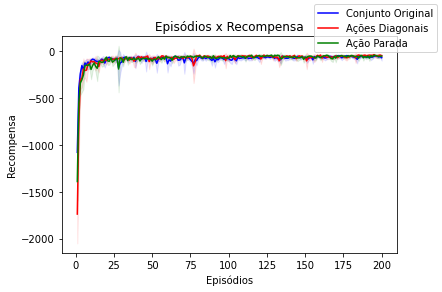

In [108]:
fig, ax = plt.subplots()
plot_with_confidence_interval(rewards_exp1, ax, 'b')
plot_with_confidence_interval(rewards_exp2, ax, 'r')
plot_with_confidence_interval(rewards_exp3, ax, 'g')

plt.xlabel('Episódios')
plt.ylabel('Recompensa')
plt.title('Episódios x Recompensa')

fig.legend(['Conjunto Original', 'Ações Diagonais', 'Ação Parada'])
plt.show()

## Em relação ao número total de passos por episódio

No gráfico abaixo temos um plot do acumulado de passos dados em cada episódio. A área sombreada é um intervalo de confiança de 95% usando a distribuição t de student com o tamanho da amostra de 50 execuções independentes do sarsa. Nota-se que a adição de ações diagonais e da ação de ficar parado ambas aceleram significativamente o aprendizado no início, mas com o decorrer dos episódios, não há diferenças significativas. Note também que não há diferença significativa entre o uso de ações diagonais e a ação extra de parada.

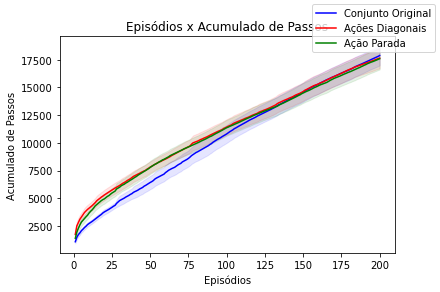

In [109]:
fig, ax = plt.subplots()
plot_with_confidence_interval(total_steps_exp1, ax, 'b')
plot_with_confidence_interval(total_steps_exp2, ax, 'r')
plot_with_confidence_interval(total_steps_exp3, ax, 'g')

plt.xlabel('Episódios')
plt.ylabel('Acumulado de Passos')
plt.title('Episódios x Acumulado de Passos')

fig.legend(['Conjunto Original', 'Ações Diagonais', 'Ação Parada'])
plt.show()

## Em relação ao número de passos por episódio

No gráfico abaixo temos um plot do número de passos dados em cada episódio. A área sombreada é um intervalo de confiança de 95% usando a distribuição t de student com o tamanho da amostra de 50 execuções independentes do sarsa. Não há diferença significativa entre a quantidade de passos em um dado episódio para cada conjunto de ações.

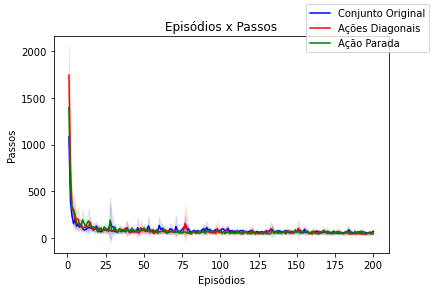

In [110]:
fig, ax = plt.subplots()
plot_with_confidence_interval(steps_exp1, ax, 'b')
plot_with_confidence_interval(steps_exp2, ax, 'r')
plot_with_confidence_interval(steps_exp3, ax, 'g')

plt.xlabel('Episódios')
plt.ylabel('Passos')
plt.title('Episódios x Passos')

fig.legend(['Conjunto Original', 'Ações Diagonais', 'Ação Parada'])
plt.show()

## Sobre a metodologia

A distribuição t de student foi usada em cada caso, e para que a comparação seja válida, é necessário que algumas coisas sejam verdade sobre os dados. As execuções do sarsa foram independentes para cada conjunto de ações, e seja qual for a distribuição original em cada episódio de cada uma das grandezas por episódio, pelo teorema do limite central, assume-se que 50 amostras sejam o suficiente para que as distribuições amostrais sejam aproximadamente normais.